In [72]:
# Topic: Omedna Plant Disease Classsification
# Author: Hariharan Ayappane
# Date: 28/8/23
# Descripion: 
# 1. The below notebook explores the application of ensembling in imae classification problems. 
# 2. The base models are Sequential, ResNet50 and InceptionV3
# 3. The base models are ensembled using averaging. But more advanced methods like Ridge Regression can be used as well.
# 4. Hyperparameter tuning is in pending  
# 5. Dataset used is from Kaggle (https://www.kaggle.com/datasets/badasstechie/coffee-leaf-diseases)
# 6. Accuracies obtained are as follows (approx):
#     a. Sequential: 72.22
#     b. ResNet50: 80.09
#     c. InceptionV3:  89.81
#     d. Ensemble: 90.98

# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
from PIL import Image
from sklearn.preprocessing import LabelEncoder

In [3]:
from tensorflow.python.client import device_lib

In [4]:
import numpy as np
import pandas as pd

In [5]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential

#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob

In [6]:
import matplotlib.pyplot as plt

In [7]:
IMAGE_SIZE = 256
CHANNELS = 3

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [10]:
def get_all_predictions(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    return predictions[0]

In [11]:
def find_class(label):
    if (label == [1, 0, 0]).all():
        return "Potato___Early_blight"
    elif (label == [0, 1, 0]).all():
        return "Potato___Late_blight"
    else:
        return "Potato___healthy"

In [12]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3104559414090055521
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2229954151
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10951490873509834626
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [13]:
IMAGE_SIZE = 256
CHANNELS = 3

# Model 1: Sequential

In [14]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        'output/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 216 images belonging to 3 classes.


In [15]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
        'output/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse",
)

Found 1721 images belonging to 3 classes.


In [16]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        'output/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 215 images belonging to 3 classes.


In [17]:
class_names = train_generator.class_indices
class_names = list(class_names.keys())

In [18]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [19]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model1 = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [20]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [21]:
model1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model1.fit(
    train_generator,
    steps_per_epoch=47,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=1,
    epochs=1,
)

47/47 [==============================] - 25s 464ms/step - loss: 0.8906 - accuracy: 0.5023 - val_loss: 0.7629 - val_accuracy: 0.7292


In [23]:
scores = model1.evaluate(test_generator)

7/7 [==============================] - 4s 532ms/step - loss: 0.7972 - accuracy: 0.7222


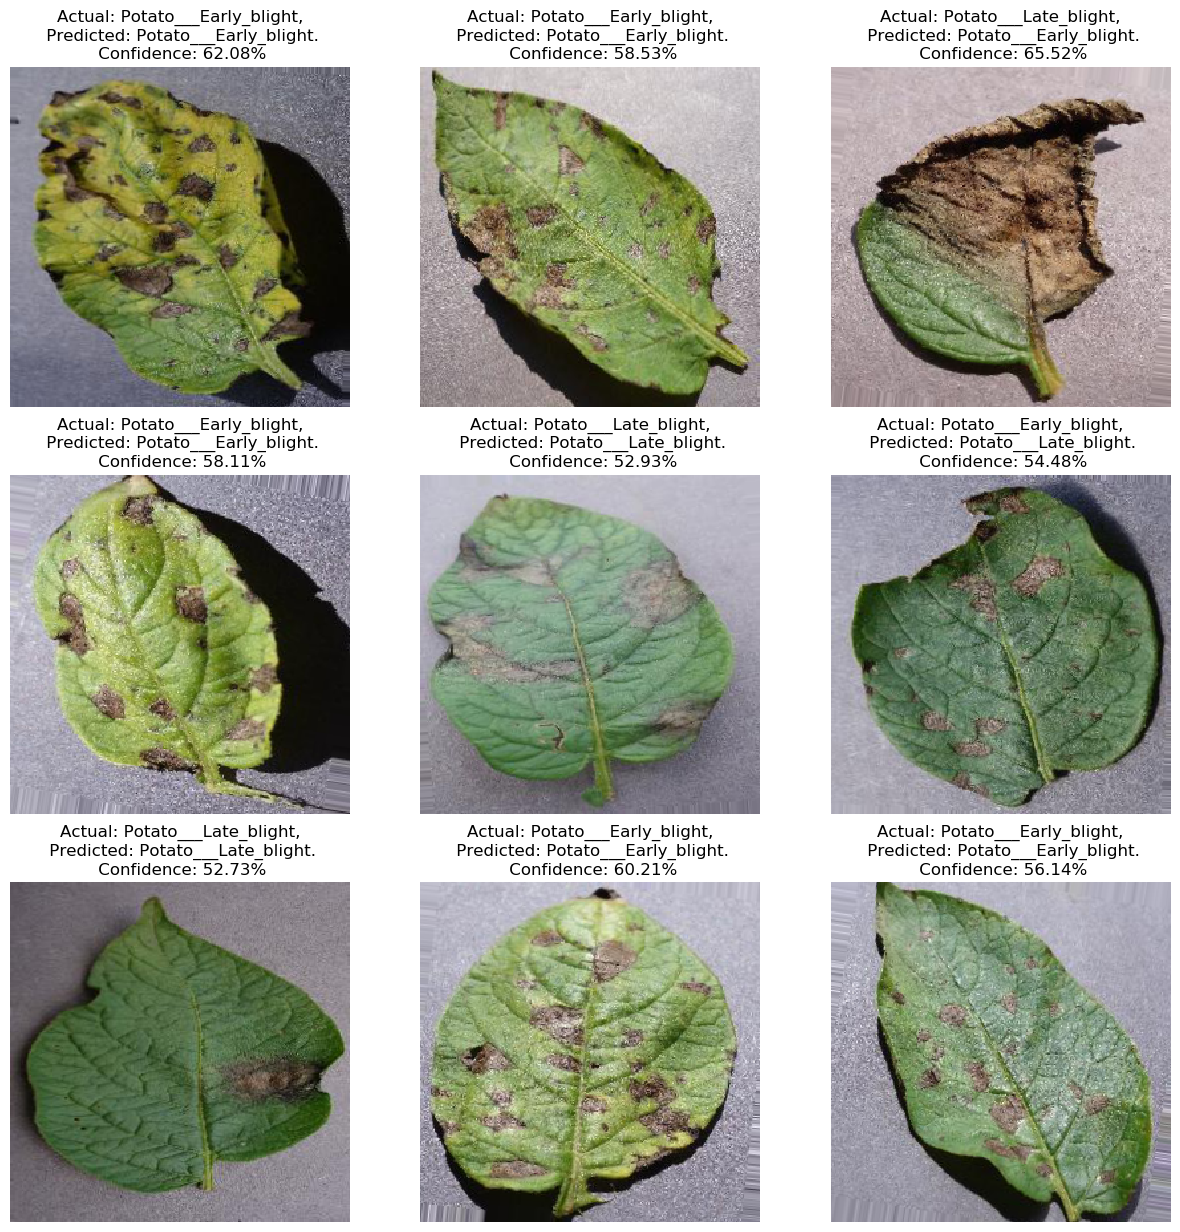

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model1, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [27]:
model1.save("./saved_models/model1.h5")

# Model 2: ResNet50

In [28]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
        'output/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="categorical",
)

Found 1721 images belonging to 3 classes.


In [29]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        'output/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="categorical"
)

Found 215 images belonging to 3 classes.


In [30]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        'output/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="categorical"
)

Found 216 images belonging to 3 classes.


In [31]:
resnet = ResNet50(input_shape=[IMAGE_SIZE] + [IMAGE_SIZE] + [CHANNELS], weights='imagenet', include_top=False)

In [32]:
for layer in resnet.layers:
    layer.trainable = False

In [33]:
resnet.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [34]:
x = Flatten()(resnet.output)

In [35]:
folders = glob('output/train/*')

In [36]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model2 = Model(inputs=resnet.input, outputs=prediction)

In [37]:
# view the structure of the model
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [38]:
# tell the model what cost and optimization method to use
model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [39]:
history = model2.fit(
    train_generator,
    steps_per_epoch=47,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=1,
    epochs=1,
)

47/47 [==============================] - 42s 766ms/step - loss: 2.7009 - accuracy: 0.6239 - val_loss: 0.7390 - val_accuracy: 0.7188


In [40]:
scores = model2.evaluate(test_generator)

7/7 [==============================] - 5s 781ms/step - loss: 0.6342 - accuracy: 0.8009


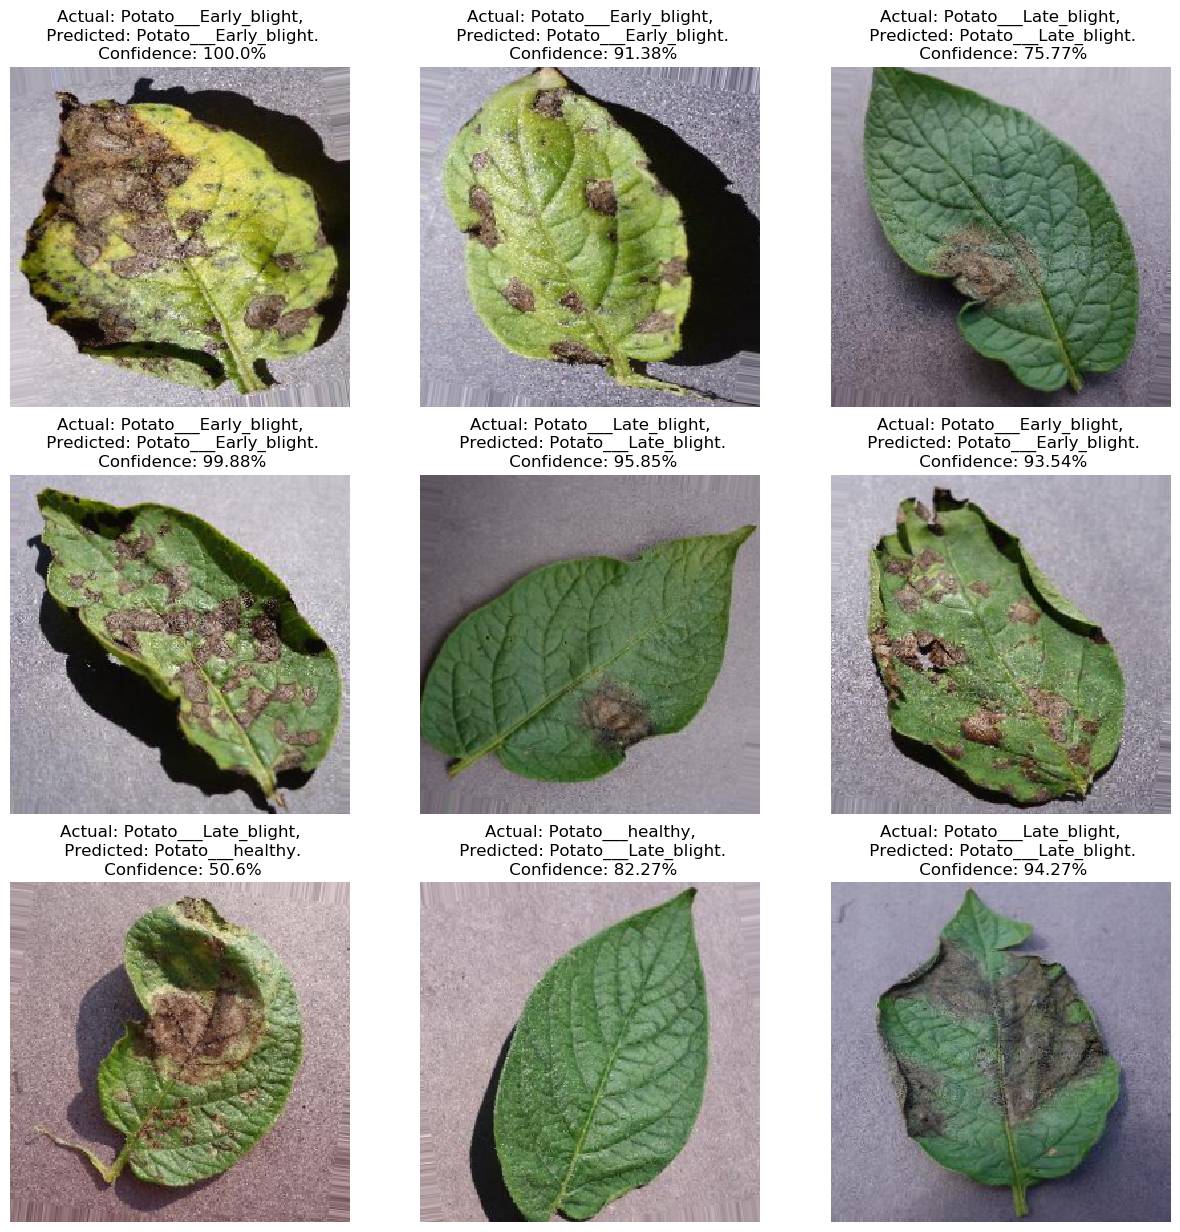

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model2, images[i])
        actual_class = find_class(labels[i])
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [42]:
model2.save("./saved_models/model2.h5")

C:\Users\haria\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Model 3 (ResNet50)

In [43]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=[IMAGE_SIZE] + [IMAGE_SIZE] + [CHANNELS], weights='imagenet', include_top=False)

In [44]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [45]:
  # useful for getting number of output classes
folders = glob('output/train/*')

In [46]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [47]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model3 = Model(inputs=inception.input, outputs=prediction)

In [48]:
# view the structure of the model
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [49]:
# tell the model what cost and optimization method to use
model3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [50]:
history = model3.fit(
    train_generator,
    steps_per_epoch=47,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=1,
    epochs=1,
)

47/47 [==============================] - 46s 768ms/step - loss: 3.6695 - accuracy: 0.7582 - val_loss: 0.6612 - val_accuracy: 0.9271


In [51]:
scores = model3.evaluate(test_generator)

7/7 [==============================] - 6s 933ms/step - loss: 0.6839 - accuracy: 0.8981


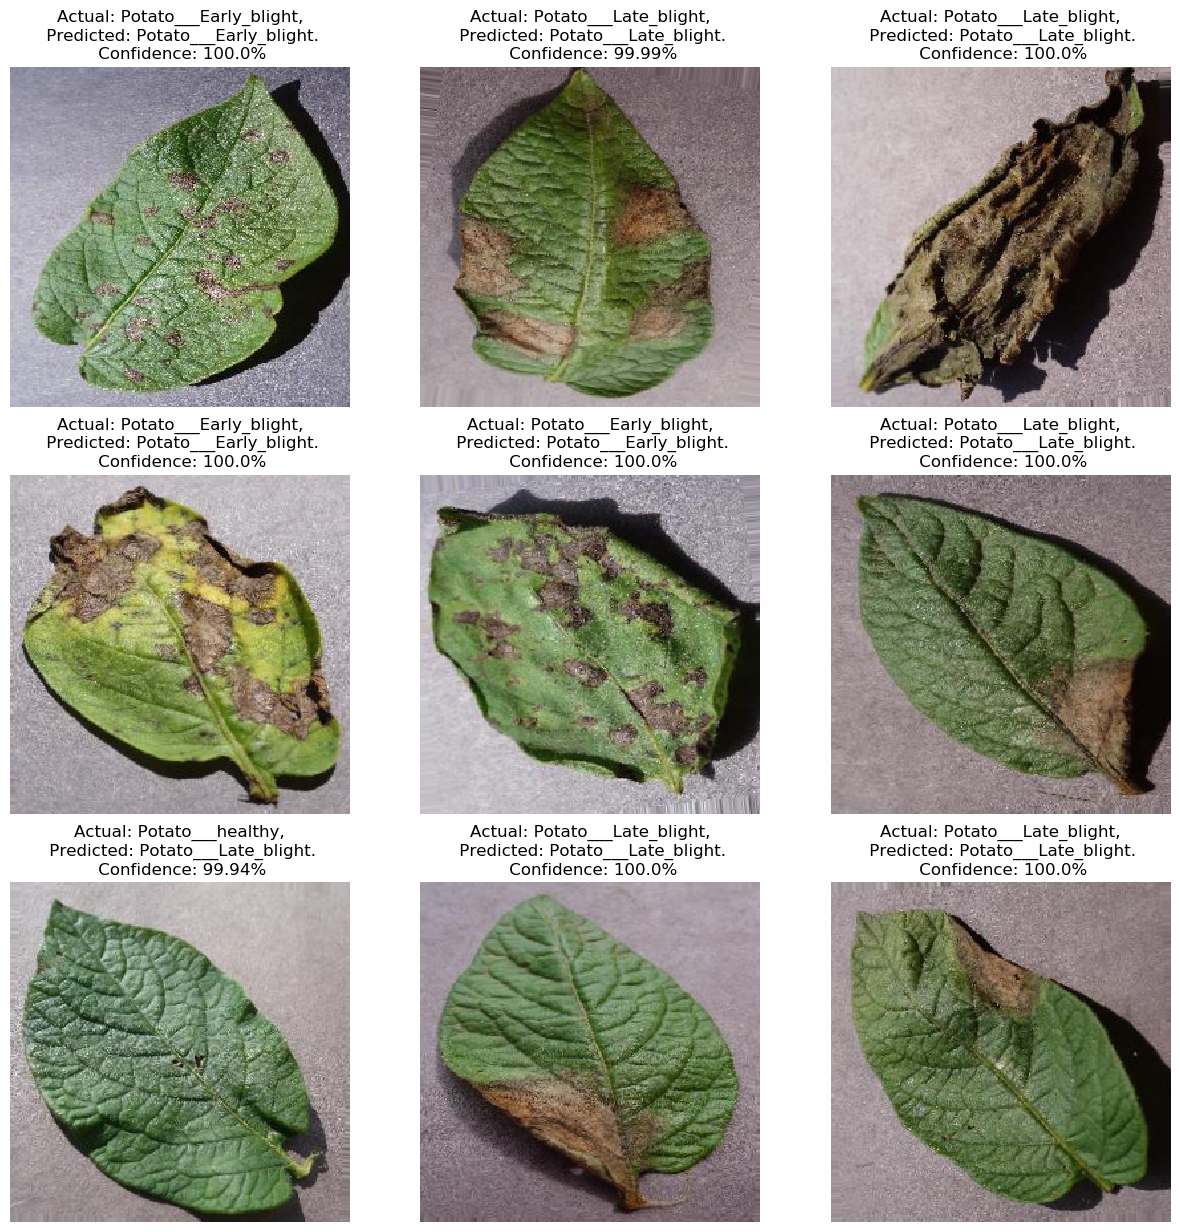

In [52]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model3, images[i])
        actual_class = find_class(labels[i])
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [53]:
model3.save("./saved_models/model3.h5")

# Prediction and Confidence Comparison (model 1 vs model 2 vs model 3)

In [55]:
# Comparision among all base models
for images, labels in test_generator:
    for i in range(1):
        predicted_class1, confidence1 = predict(model1, images[i])
        predicted_class2, confidence2 = predict(model2, images[i])
        predicted_class3, confidence3 = predict(model3, images[i])
        actual_class = find_class(labels[i])
        print(f"Actual: {actual_class}")
        print(f"Predicted1: {predicted_class1}.\n Confidence1: {confidence1}%")
        print(f"Predicted2: {predicted_class2}.\n Confidence2: {confidence2}%")
        print(f"Predicted3: {predicted_class3}.\n Confidence3: {confidence3}%")
        print()
    break

Actual: Potato___Early_blight
Predicted1: Potato___Early_blight.
 Confidence1: 52.57%
Predicted2: Potato___healthy.
 Confidence2: 51.77%
Predicted3: Potato___Early_blight.
 Confidence3: 92.78%


# Ensemble (Using Averaging)

In [59]:
for images, labels in test_generator:
    for i in range(1):
        all_predictions1 = get_all_predictions(model1, images[i])
        all_predictions2 = get_all_predictions(model2, images[i])
        all_predictions3 = get_all_predictions(model3, images[i])
        
        actual_class = find_class(labels[i])
        print(f"Actual: {actual_class}")
        
        final = (all_predictions1 + all_predictions2 + all_predictions3)/3
        predicted_class = class_names[np.argmax(final)]
        print(f"Predicted: {predicted_class}")
    break

Actual: Potato___Late_blight
Predicted: Potato___Late_blight


In [74]:
tot = 0
corr = 0
for images, labels in test_generator:
    for i in range(len(images)):
        all_predictions1 = get_all_predictions(model1, images[i])
        all_predictions2 = get_all_predictions(model2, images[i])
        all_predictions3 = get_all_predictions(model3, images[i])
        
        actual_class = find_class(labels[i])
        print(f"Actual: {actual_class}")
        
        final = (all_predictions1 + all_predictions2 + all_predictions3)/3
        predicted_class = class_names[np.argmax(final)]
        print(f"Predicted: {predicted_class}")
        if(predicted_class == actual_class):
            corr = corr + 1
        tot = tot + 1
#     break

Actual: Potato___Early_blight
Predicted: Potato___Early_blight
Actual: Potato___Late_blight
Predicted: Potato___Late_blight
Actual: Potato___Late_blight
Predicted: Potato___Late_blight
Actual: Potato___Late_blight
Predicted: Potato___Late_blight
Actual: Potato___healthy
Predicted: Potato___Late_blight
Actual: Potato___Late_blight
Predicted: Potato___Late_blight
Actual: Potato___Early_blight
Predicted: Potato___Early_blight
Actual: Potato___Early_blight
Predicted: Potato___Early_blight
Actual: Potato___Early_blight
Predicted: Potato___Early_blight
Actual: Potato___Late_blight
Predicted: Potato___Late_blight
Actual: Potato___Late_blight
Predicted: Potato___Late_blight
Actual: Potato___Late_blight
Predicted: Potato___Late_blight
Actual: Potato___Late_blight
Predicted: Potato___Late_blight
Actual: Potato___Late_blight
Predicted: Potato___Late_blight
Actual: Potato___Early_blight
Predicted: Potato___Early_blight
Actual: Potato___Late_blight
Predicted: Potato___Late_blight
Actual: Potato___L

KeyboardInterrupt: 

In [75]:
print('Accuracy: ', corr/tot)

Accuracy:  0.9098923894723194
